In [1]:
%matplotlib notebook

import numpy as np
import h5py
import matplotlib.pyplot as plt
import math
from scipy.integrate import dblquad

In [128]:
temp = 0.0001
jacobian = False
experiment_name = 'banchoff_chmutov4'
mcmc_type = 'nuts'
bounded = False

jacobian_str = '_jacobian' if jacobian else ''
bounded_str = '_bounded' if bounded else ''
data = h5py.File('results/' + experiment_name + '/temp_' + str(temp) + jacobian_str + bounded_str + '_' + mcmc_type + '_result.hdf5', 'r')

overall_xs = np.array(data['overall_xs'])
x_coords = data['x_coords']
y_coords = data['y_coords']
z_coords = data['z_coords']
# gradients = data['gradient']
density = data['prob']
f_values = data['f_values']



<IPython.core.display.Javascript object>


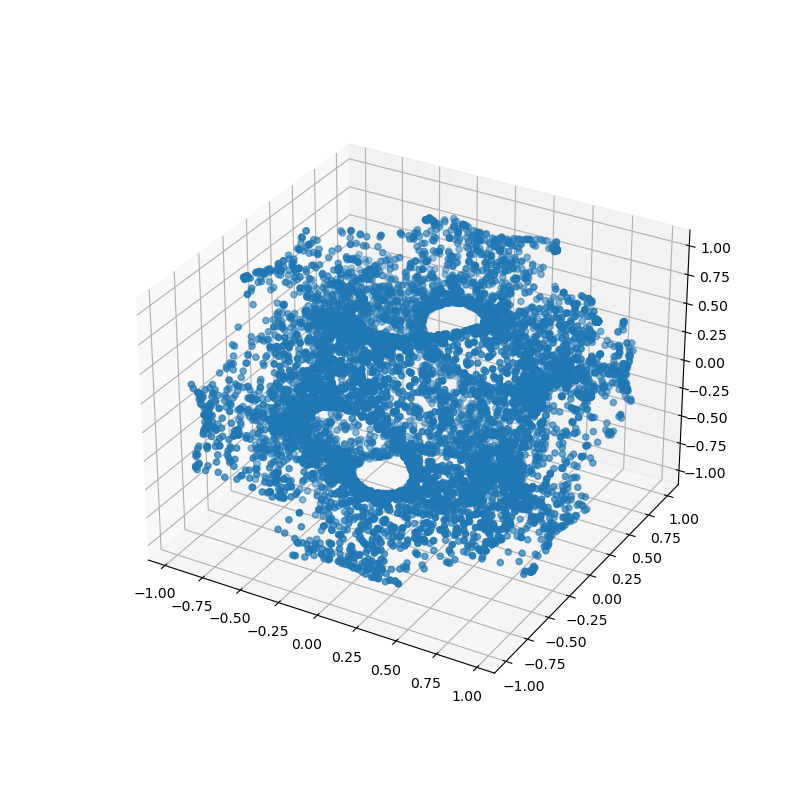

In [129]:
x = overall_xs[:,0]
y = overall_xs[:,1]
z = overall_xs[:, 2]

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z)
plt.show()

<IPython.core.display.Javascript object>


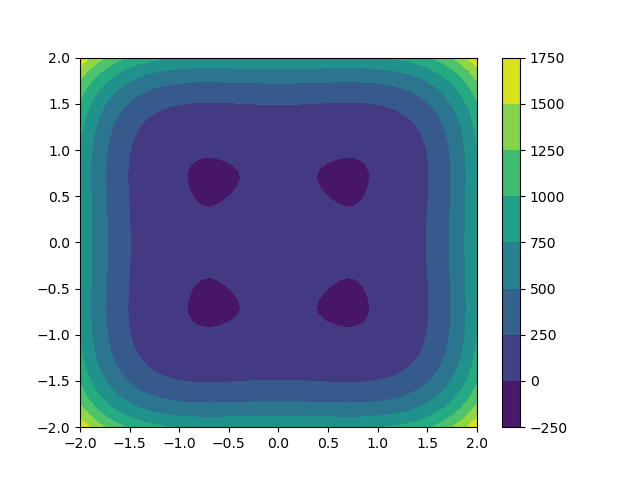

/var/folders/bt/l8m0v7fn01vf32zwtjgd7mtr0000gn/T/ipykernel_88395/2454812857.py:4: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(CS)


In [122]:
fig = plt.figure()
half = len(f_values)//2
plt.contourf(x_coords[half, :, :], z_coords[half,:, :], f_values[half,:, :])
cbar = fig.colorbar(CS)
plt.show()

<IPython.core.display.Javascript object>


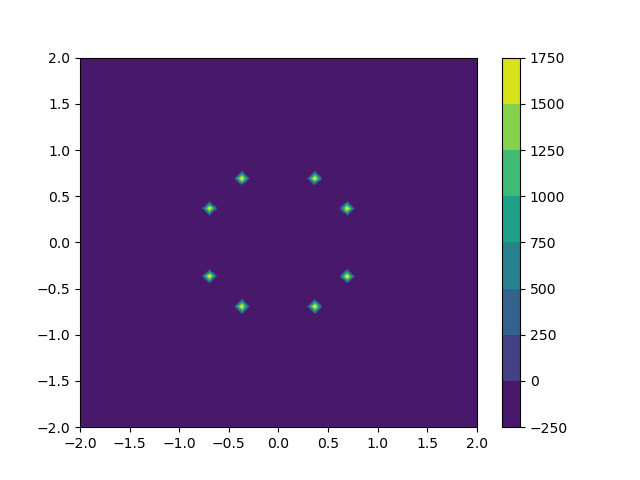

/var/folders/bt/l8m0v7fn01vf32zwtjgd7mtr0000gn/T/ipykernel_88395/746156666.py:4: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(CS)


In [123]:
fig = plt.figure()
half = len(density)//2
plt.contourf(x_coords[half, :, :], z_coords[half,:, :], density[half,:, :])
cbar = fig.colorbar(CS)
plt.show()

In [12]:
def calc_y(y_value, min_z, max_z, func, sign, c):
    result = y_value
    if min_z <= c and -c <= min_z:
        result = func(result, sign* b*math.sqrt(1 - (min_z/c)**2))
    if max_z <= c and -c <= max_z:
        result = func(result, sign * b*math.sqrt(1 - (max_z/c)**2))
    return result

def count_samples(min_values, max_values):
    min_restrict = np.all(overall_xs >= min_values, axis=1)
    max_restrict = np.all(overall_xs <= max_values, axis=1)
    within_range = np.logical_and(min_restrict, max_restrict)
    return np.sum(within_range.astype(float))

def calc_surface_area(min_values, max_values, a, b, c):
    min_x, min_y, min_z = min_values
    max_x, max_y, max_z = max_values
    def integral_func(z, y):
        x = math.sqrt(1 - (z / c)**2 - (y / b)**2) * a
        return math.sqrt(1 + (a**2 * y / (b**2 * x))**2 + (a**2 * z / (c**2 * x))**2)

    def min_z_func(y):
        min_z_value = -c*math.sqrt(1 - (y/b)**2 - (min_x/a)**2)
        return max(min_z,  min_z_value)

    def max_z_func(y):
        return min(max_z, c*math.sqrt(1 - (y/b)**2))

    actual_min_y = calc_y(min_y, min_z, max_z, max, -1, c)
    actual_max_y = calc_y(max_y, min_z, max_z, min, 1, c)

    surface_area = dblquad(integral_func, actual_min_y, actual_max_y, min_z_func, max_z_func)[0]
    return surface_area

def calc_samples_respect_area(a, b, c, num_samples, grid_size, overall_xs):
    ratios = []
    z_range = np.linspace(- c, c, num_samples)

    for z in z_range:
        y = 0
        x = math.sqrt(1 - (z / c)**2 ) * a

        min_z, max_z = z - grid_size/2, z + grid_size/2
        min_y, max_y = y - grid_size/2, y + grid_size/2
        min_x, max_x = x - grid_size/2, x + grid_size/2

        min_values = [min_x, min_y, min_z]
        max_values = [max_x, max_y, max_z] 
        surface_area = calc_surface_area(min_values, max_values, a, b, c)
        num_samples = count_samples(min_values, max_values)
        ratios.append(num_samples/surface_area/overall_xs.shape[0])
        
    return ratios, z_range

def avg_density(min_values, max_values, num_density_samples=10):
    pass
    

def calc_density_respect_area(a, b, c, num_samples, grid_size, overall_xs):
    ratios = []
    z_range = np.linspace(- c, c, num_samples)

    for z in z_range:
        y = 0
        x = math.sqrt(1 - (z / c)**2 ) * a

        min_z, max_z = z - grid_size/2, z + grid_size/2
        min_y, max_y = y - grid_size/2, y + grid_size/2
        min_x, max_x = x - grid_size/2, x + grid_size/2
        
        min_values = [min_x, min_y, min_z]
        max_values = [max_x, max_y, max_z] 
        surface_area = calc_surface_area(min_values, max_values, a, b, c)
        ratios.append(num_samples/surface_area/overall_xs.shape[0])
        
    return ratios, z_range
    

<IPython.core.display.Javascript object>


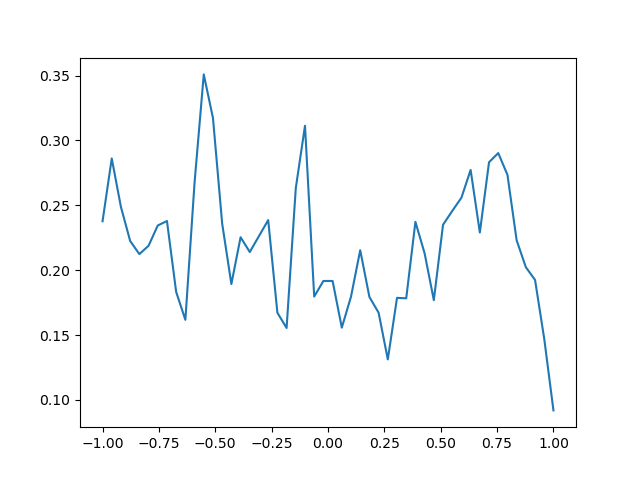

In [13]:
scaling = 3.
a = 1. / scaling
b = 2. / scaling
c = 3. / scaling

num_samples = 50
grid_size = 0.1

ratios, z_range = calc_samples_respect_area(a,b,c, num_samples, grid_size, overall_xs)
    
plt.figure()
plt.plot(z_range, ratios)
plt.show()
    

<IPython.core.display.Javascript object>


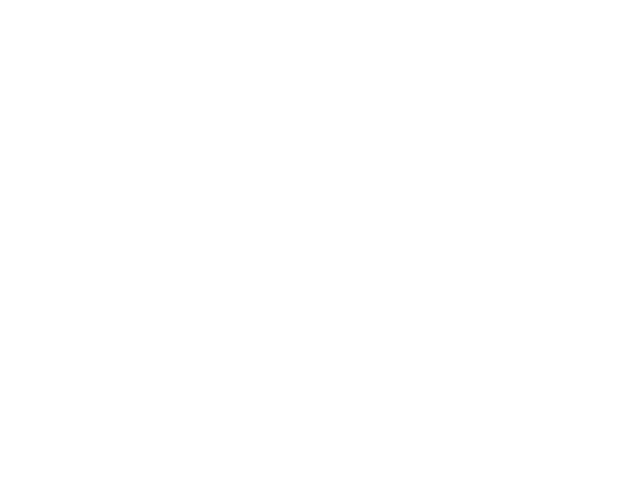

<IPython.core.display.Javascript object>


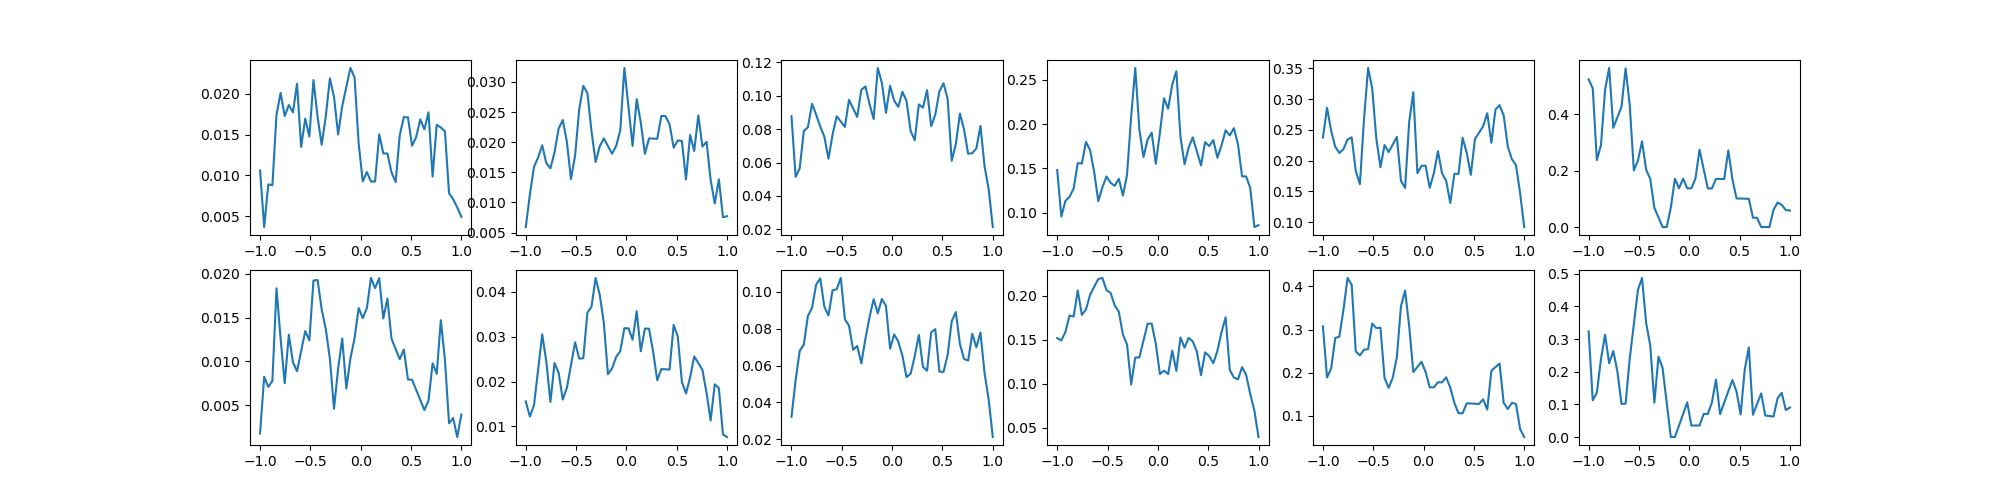

In [14]:
scaling = 3.
a = 1. / scaling
b = 2. / scaling
c = 3. / scaling

num_samples = 50
grid_size = 0.1

temps = [1., 0.1, 0.01, 0.001, 0.0001, 0.00001]
jacobians = [True, False]
fig = plt.figure()
subfigs, axs = plt.subplots(len(jacobians), len(temps), figsize=(20,5))
for idx, temp in enumerate(temps):
    for idx2, jacobian_value in enumerate(jacobians):
        jacobian_str = '_jacobian' if jacobian_value else ''
        data_value = h5py.File('results/temp_' + str(temp) + jacobian_str + '_reject_result.hdf5', 'r')
        overall_xs = np.array(data_value['overall_xs'])
        ratios, z_range = calc_samples_respect_area(a,b,c, num_samples, grid_size, overall_xs)
        axs[idx2, idx].plot(z_range, ratios)
        

<IPython.core.display.Javascript object>


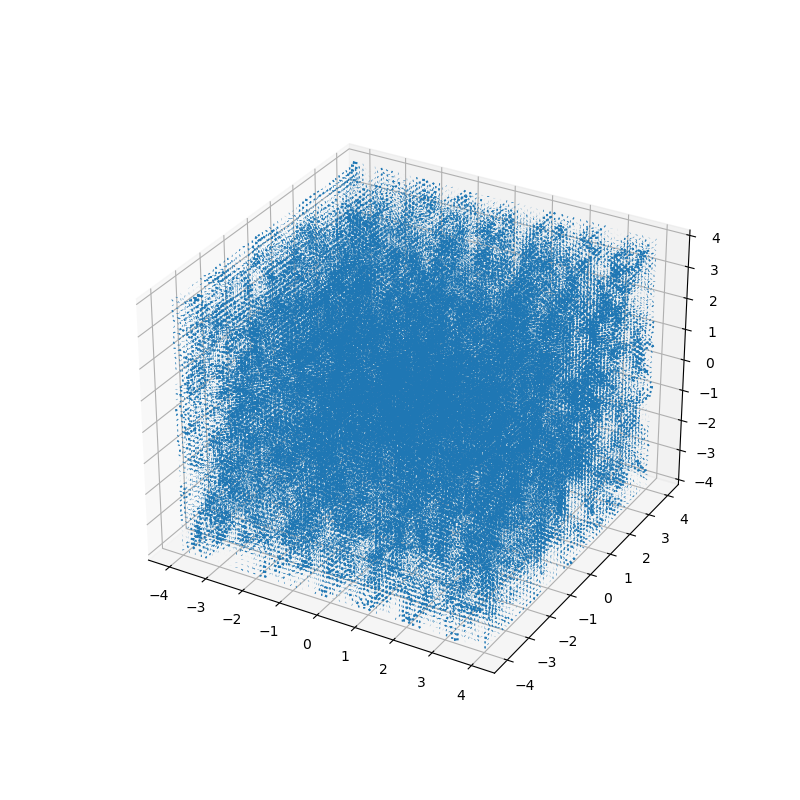

In [151]:
fig = plt.figure(figsize=(8,8))
scaled_gradients = np.array(gradients) * 0.001
ax = fig.add_subplot(111, projection='3d')
ax.quiver(x_coords, y_coords, z_coords, scaled_gradients[:,:, :, 0], scaled_gradients[:,:, :,1], scaled_gradients[:,:, :,2])
plt.show()